# Mark PCR duplicates

This notebook profile the threshold for marking PCR duplicates.

In [1]:
import os
import random
import edlib
import multiprocessing as mp
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyBioInfo.IO.File import BamFile
from pyBioInfo.Utils import BundleBuilder

## 1. Random UMI edit distance (barplot)

In [2]:
def load_random_umi_edit_distance(path):
    random.seed(0)
    reads = []
    with BamFile(path, random=True) as f:
        for bundle in BundleBuilder(f, keep=True):
            reads.append(random.sample(bundle.data, 1)[0])   
    umis = [read.segment.get_tag("UM") for read in reads]
    eds = []
    for i in range(len(umis) - 1):
        for j in range(i + 1, len(umis)):
            umi1, umi2 = umis[i], umis[j]
            if len(umi1) > len(umi2):
                umi1, umi2 = umi2, umi1
            eds.append(edlib.align(umi1, umi2, mode="HW")["editDistance"])
    return Counter(eds)

paths = [
    "../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R1/20220719_K562R1.C01.bam",
    "../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R1/20220719_K562R1.C02.bam",
    "../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R1/20220719_K562R1.C03.bam",
    "../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R1/20220719_K562R1.C04.bam",
    "../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R1/20220719_K562R1.C05.bam",
    "../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R1/20220719_K562R1.C06.bam",
    "../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R1/20220719_K562R1.C07.bam",
    "../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R1/20220719_K562R1.C08.bam",
    "../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R1/20220719_K562R1.C09.bam",
    "../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R1/20220719_K562R1.C10.bam"]

array = []
pool = mp.Pool(10)
for path in paths:
    array.append(pool.apply_async(load_random_umi_edit_distance, (path,)))
pool.close()
pool.join()
array = [r.get() for r in array]

[W::hts_idx_load3] The index file is older than the data file: ../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R1/20220719_K562R1.C07.bam.bai
[W::hts_idx_load3] The index file is older than the data file: ../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R1/20220719_K562R1.C09.bam.bai
[W::hts_idx_load3] The index file is older than the data file: ../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R1/20220719_K562R1.C08.bam.bai
[W::hts_idx_load3] The index file is older than the data file: ../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R1/20220719_K562R1.C02.bam.bai
[W::hts_idx_load3] The index file is older than the data file: ../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R1/20220719_K562R1.C04.bam.bai
[W::hts_idx_load3] The index file is older than the data file: ../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R1/20220719_K562R1.C03.bam.bai
[W::hts_idx_load3] The index file is older than the data file: ../../1

Cells: 10


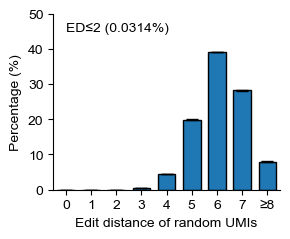

In [3]:
print("Cells:", len(array))
ed_max = 8
rows = []
for counter in array:
    row = np.zeros(ed_max + 1)
    for ed, count in counter.items():
        row[min(ed, len(row) - 1)] += count
    rows.append(row)
d = pd.DataFrame(rows)
columns = list(map(str, d.columns))
columns[-1] = "≥%s" % columns[-1]
d.columns = columns
d1 = d.divide(d.sum(axis=1), axis=0) * 100

ys = d1.mean(axis=0)
yerr = d1.std(axis=0)
xs = np.arange(len(ys))
ticks = d1.columns
plt.figure(figsize=(3, 2.5))
plt.bar(xs, ys, yerr=yerr, edgecolor="black", width=0.7, color="C0", error_kw={"capsize": 4})
if False:
    plt.plot([-0.3, 2.3], [10, 10], color="red", lw=2)
    plt.text(1, 11, "%.4f%%" % sum(ys[:3]), ha="center", va="bottom", color="red")
else:
    plt.text(0, 45, "ED≤2 (%.4f%%)" % sum(ys[:3]))
plt.xticks(xs, ticks)
plt.xlabel("Edit distance of random UMIs")
plt.ylabel("Percentage (%)")
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 50)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/random_cluster_umi_ed.pdf")

## 2. Number of UMI (violinplot)

In [2]:
d = pd.read_csv("../../1_FLAIRseq/reports/FLAIRseq_Summary.tsv", sep="\t")
d1 = d[(d["CellLine"] == "K562") & (d["s4U"] == 0) & (d["Time"] == 3) & (d["ActD"].isna())]
d2 = d[(d["CellLine"] == "K562") & (d["s4U"] == 50) & (d["Time"] == 3) & (d["ActD"].isna())]
d3 = d[(d["CellLine"] == "mESC") & (d["s4U"] == 0) & (d["Time"] == 3) & (d["ActD"].isna())]
d4 = d[(d["CellLine"] == "mESC") & (d["s4U"] == 400) & (d["Time"] == 3) & (d["ActD"].isna())]
print(len(d1), len(d2), len(d3), len(d4), sep="\t")

199	189	64	123


In [3]:
rows = []
x = 0
for d in [d1, d2, d3, d4]:
    for v in d["UMIs"]:
        rows.append([x, v])
    x += 1
for d in [d1, d2, d3, d4]:
    for v in d["UMIs.2Reads"]:
        rows.append([x, v])
    x += 1
d = pd.DataFrame(rows, columns=["Type", "UMIs"])

In [4]:
print("Type\tMedian\tMean\t25%\t75%")
for k, v in sorted(d.groupby(by="Type")):
    vs = list(sorted(v["UMIs"]))
    print(k, np.median(vs), round(np.mean(vs), 1),  vs[int(len(vs) * 0.25)], vs[int(len(vs) * 0.75)], sep="\t")

Type	Median	Mean	25%	75%
0	14974.0	14815.2	10401	19337
1	11633.0	12810.0	8140	16593
2	14726.0	15208.9	11042	19352
3	9303.0	9733.1	7331	11723
4	8437.0	8580.5	5982	11424
5	6799.0	7557.7	4831	10048
6	9192.5	9311.2	6798	11790
7	5786.0	6112.5	4483	7499


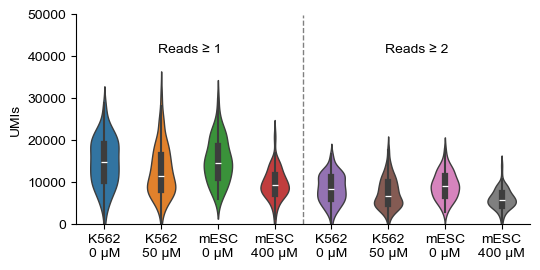

In [5]:
colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7"]
# colors = ["C0", "C0", "C0", "C0", "C1", "C1", "C1", "C1"]
xs = np.arange(8)
plt.figure(figsize=(5.5, 2.8))
ret = sns.violinplot(data=d, x="Type", hue="Type", y="UMIs", 
                     density_norm="area", legend=False, width=0.5, linewidth=1, palette=colors)
plt.xlim(-0.5, 7.5)
plt.ylim(0, 50000)
plt.axvline(3.5, lw=1, color="grey", ls="--")
plt.text(1.5, 40000, "Reads ≥ 1", ha="center", va="bottom")
plt.text(5.5, 40000, "Reads ≥ 2", ha="center", va="bottom")
plt.xlabel(None)
plt.xticks(xs, [
    "K562\n0 μM", "K562\n50 μM", "mESC\n0 μM", "mESC\n400 μM", 
    "K562\n0 μM", "K562\n50 μM", "mESC\n0 μM", "mESC\n400 μM"])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/umi_counts.pdf")

## 3. Reads per UMI (barplot)

In [6]:
d = pd.read_csv("../../1_FLAIRseq/reports/FLAIRseq_Summary.tsv", sep="\t")
d1 = d[(d["CellLine"] == "K562") & (d["s4U"] == 0) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["UMIs"] >= 5000)]
d2 = d[(d["CellLine"] == "K562") & (d["s4U"] == 50) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["UMIs"] >= 5000)]
d3 = d[(d["CellLine"] == "mESC") & (d["s4U"] == 0) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["UMIs"] >= 5000)]
d4 = d[(d["CellLine"] == "mESC") & (d["s4U"] == 400) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["UMIs"] >= 5000)]
print(len(d1), len(d2), len(d3), len(d4), sep="\t")

190	179	64	112


In [7]:
params = [
    ["K562", 0, 3, d1],
    ["K562", 50, 3, d2],
    ["mESC", 0, 3, d3],
    ["mESC", 400, 3, d4],
]

data = dict()
for d in [d1, d2, d3, d4]:
    for cell in d["Cell"]:
        path = "../../1_FLAIRseq/results/mapping/mark_duplicate/%s/%s.tsv" % (cell.split(".")[0], cell)
        data[cell] = pd.read_csv(path, sep="\t", header=0)

--------------------------------------------------------------------------------
K562	0	3	190
reads = 1: 42.19 ± 2.38 %
reads = 2: 12.15 ± 1.16 %
--------------------------------------------------------------------------------
K562	50	3	179
reads = 1: 41.03 ± 2.60 %
reads = 2: 11.92 ± 1.38 %
--------------------------------------------------------------------------------
mESC	0	3	64
reads = 1: 38.94 ± 2.38 %
reads = 2: 11.95 ± 1.14 %
--------------------------------------------------------------------------------
mESC	400	3	112
reads = 1: 37.36 ± 1.89 %
reads = 2: 10.05 ± 1.43 %


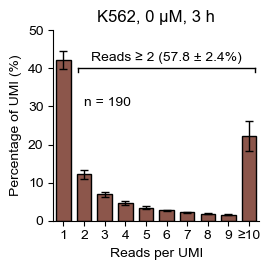

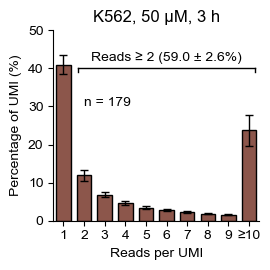

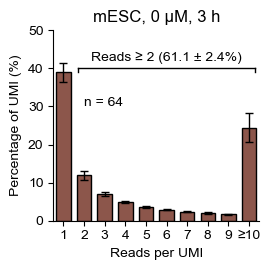

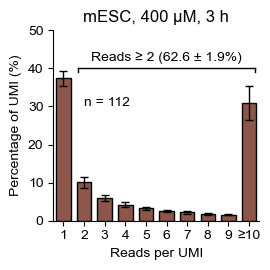

In [12]:
for cell_line, s4u, time, d in params:
    print("-" * 80)
    print(cell_line, s4u, time, len(d), sep="\t")
    
    rows = []
    for cell in d["Cell"]:
        counter = Counter(data[cell]["AllSize"])
        row = [counter[i] for i in range(10)]
        row.append(sum(counter.values()) - sum(row))
        rows.append(row)
    m = pd.DataFrame(rows)
    m.columns = np.arange(11)
    m = m[m.columns[1:]]
    m = m[m.sum(axis=1) >= 5000] # UMIs >= 5000
    m = m.divide(m.sum(axis=1), axis=0) * 100
    
    ys = m.mean(axis=0)
    yerr = m.std(axis=0)
    print("reads = 1: %.2f ± %.2f %%" % (ys[1], yerr[1]))
    print("reads = 2: %.2f ± %.2f %%" % (ys[2], yerr[2]))
    
    xs = m.columns
    xticks = list(xs)
    xticks[-1] = "≥10"
    plt.figure(figsize=(2.8, 2.8))
    plt.title("%s, %d μM, %d h" % (cell_line, s4u, time))
    plt.bar(xs, ys, yerr=yerr, color="C5", edgecolor="black", width=0.7,
            error_kw={"capsize": 3, "capthick": 1, "lw": 1})
    plt.text(2, 30, "n = %d" % len(d))
    if True:
        vs = m[m.columns[m.columns >= 2]].sum(axis=1)
        y = 40
        lw = 1
        plt.text(6, y + 2, "Reads ≥ 2 (%.1f ± %.1f%%)" % (np.mean(vs), np.std(vs)), ha="center")
        plt.plot([2 - 0.3, 10 + 0.3], [y, y], lw=lw, color="black")
        plt.plot([2 - 0.3, 2 - 0.3], [y, y - 1], lw=lw, color="black")
        plt.plot([10 + 0.3, 10 + 0.3], [y, y - 1], lw=lw, color="black")
            
    plt.xlim(0.5, 10.5)
    plt.ylim(0, 50)
    plt.xticks(xs, xticks)
    plt.xlabel("Reads per UMI")
    plt.ylabel("Percentage of UMI (%)")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/reads_per_umi.%s.%duM_%dh.pdf" % (cell_line, s4u, time))

## 4. Select reads for IGV visualization (IGV)

Gene: GAPDH

In [47]:
import pysam
bamfile = "../../1_FLAIRseq/results/mapping/mark_duplicate/20220729_K562R1/20220729_K562R1.C02.bam"
outfile = "results/20220729_K562R1.C02.GAPDH2.forIGV.bam"
with pysam.AlignmentFile(bamfile) as f, pysam.AlignmentFile(outfile, "wb", f) as fw:
    data = defaultdict(list)
    for s in f.fetch("chr12", 6534298, 6538480):
        data[s.get_tag("UM")].append(s)
    segments = []
    random.seed(0)
    for k, v in data.items():
        if len(v) > 3:
            segments.extend(random.sample(v, 3))
        else:
            segments.extend(v)
    for s in sorted(segments, key=lambda s: s.reference_start):
        fw.write(s)
! samtools index {outfile}